In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf as autocorrelation, kpss, adfuller
%matplotlib inline
import seaborn as sns
from scipy.stats.stats import pearsonr

In [2]:
%config InlineBackend.figure_format = 'png'

In [3]:
df = pd.read_excel('standard_of_living.xlsx')
df

,t,ARW,GRP,EMPR,POVR,RET,INFL
0,2000,3503.4,71281.0,0.590,0.244,52245.2,20.20
1,2001,4813.3,80038.8,0.597,0.246,63365.3,18.58
2,2002,6171.4,77729.0,0.617,0.256,75906.2,15.06
3,2003,7366.8,92547.5,0.632,0.247,89835.7,11.99
4,2004,8673.7,125287.8,0.641,0.228,105790.3,11.74
5,2005,10502.4,152389.0,0.637,0.214,126622.7,10.91
6,2006,12471.7,205042.4,0.637,0.192,162543.3,9.00
7,2007,15510.0,258394.3,0.638,0.158,213665.2,11.87
8,2008,18934.7,260318.2,0.626,0.162,276011.9,13.28
9,2009,20277.0,264478.7,0.624,0.177,279179.1,8.80


In [4]:
#это приложение Б будет
df.describe().drop(columns='t', index='count')

,ARW,GRP,EMPR,POVR,RET,INFL
mean,23141.945000,366981.760000,0.636900,0.192950,304942.490000,9.941500
std,14518.933208,256150.973224,0.018487,0.033467,183257.858773,4.798288
min,3503.400000,71281.000000,0.590000,0.156000,52245.200000,2.520000
25%,10045.225000,145613.700000,0.630500,0.170750,121414.600000,6.362500
50%,21765.600000,318663.400000,0.641500,0.180000,295734.850000,9.955000
75%,34651.350000,516075.725000,0.649500,0.217500,477701.350000,12.220000
max,49932.200000,938016.700000,0.661000,0.256000,578805.800000,20.200000


In [5]:
df.drop('t', axis=1).corr()

,ARW,GRP,EMPR,POVR,RET,INFL
ARW,1.000000,0.985096,0.735677,-0.708571,0.986737,-0.794904
GRP,0.985096,1.000000,0.689777,-0.644938,0.948291,-0.774997
EMPR,0.735677,0.689777,1.000000,-0.687000,0.751872,-0.791662
POVR,-0.708571,-0.644938,-0.687000,1.000000,-0.769131,0.670853
RET,0.986737,0.948291,0.751872,-0.769131,1.000000,-0.776959
INFL,-0.794904,-0.774997,-0.791662,0.670853,-0.776959,1.000000


In [6]:
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)

In [7]:
set(df.columns) - set(['t', 'INC'])

{'ARW', 'EMPR', 'GRP', 'INFL', 'POVR', 'RET'}

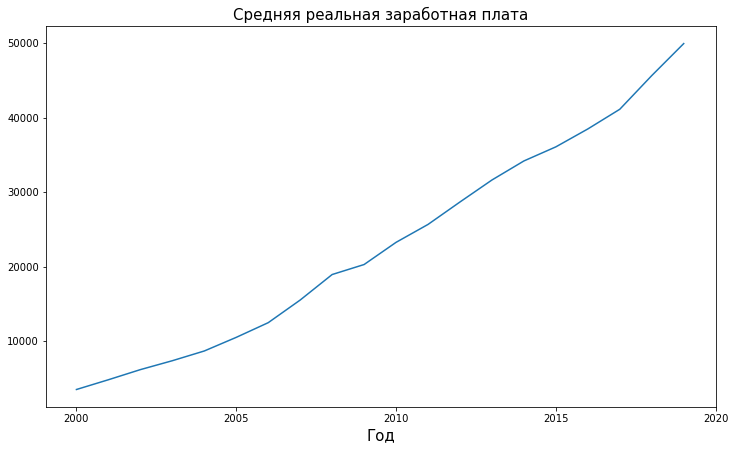

In [9]:
fig1, ax1 = plt.subplots(figsize = (12, 7))
ax1.plot(df.t, df.ARW)
ax1.set_title("Средняя реальная заработная плата", size = 15)
ax1.set_xlabel('Год', size = 15)
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.show();

In [9]:
X = df.drop(columns=['t', 'ARW'])
y = df.ARW

In [10]:
def get_pict(y_true, y_pred, regression_type):
    fig1, ax1 = plt.subplots(figsize = (12, 7))
    ax1.plot(np.arange(1, len(df) + 1), y_true, label = 'Исторические данные')
    ax1.plot(np.arange(1, len(df) + 1), y_pred, label = 'Прогнозные значения')
    ax1.set_title(regression_type, size = 15)
    ax1.set_xlabel('Момент времени t', size = 15)
    ax1.set_ylabel('Значение прогнозного признака', size = 15)
    ax1.legend(loc = 'upper left')
    plt.show();
    
def get_pict_factor(factor, n):
    get_pict(trends[factor]["Pic"][n][0], trends[factor]["Pic"][n][1], trends[factor]["Pic"][n][2])
    
def get_pict_res(factor, n):
    fig1, ax1 = plt.subplots(figsize = (12, 7))
    ax1.plot(np.arange(1, len(df) + 1), trends[factor]["Res"][n], label = 'Исследуемый на стационарность ряд остатков')
    ax1.set_title("Ряд случайных остатков", size = 15)
    ax1.set_xlabel('Момент времени t', size = 15)
    ax1.set_ylabel('Значение случайных остатков', size = 15)
    ax1.legend(loc = 'upper left')
    plt.show();

In [11]:
def linear(y):
    model = smf.ols(f'{y} ~ t', data=df).fit()
    regression_type = "Линейный тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], model.fittedvalues, regression_type, sign), (R_2, R_2_adj, F_st)

def hyperbolic(y):
    model = smf.ols(f'{y} ~ I(1/t)', data=df).fit()
    regression_type = "Гиперболический тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], model.fittedvalues, regression_type, sign), (R_2, R_2_adj, F_st)

def parabolic(y):
    model = smf.ols(f'{y} ~ t + I(t*t)', data=df).fit()
    regression_type = "Параболический тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], model.fittedvalues, regression_type, sign), (R_2, R_2_adj, F_st)

def semi_logarithmic(y):
    model = smf.ols(f'{y} ~ np.log(t)', data=df).fit()
    regression_type = "Полулагорифмический тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], model.fittedvalues, regression_type, sign), (R_2, R_2_adj, F_st)
    
def polynom_3rd_degree(y):
    model = smf.ols(f'{y} ~ t + I(t*t) + I(t*t*t)', data=df).fit()
    regression_type = "Тренд полином третьей степени"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], model.fittedvalues, regression_type, sign), (R_2, R_2_adj, F_st)

def exponential(y):
    model = smf.ols(f'np.log({y}) ~ t', data=df).fit()
    regression_type = "Показательный тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], np.exp(model.fittedvalues), regression_type, sign), (R_2, R_2_adj, F_st)

def power(y):
    model = smf.ols(f'np.log({y}) ~ np.log(t)', data=df).fit()
    regression_type = "Степенной тренд"
    res = model.summary().tables[0].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    F_st = res.loc["Date:"][-1]
    R_2_adj = res.loc["Model:"][-1]
    R_2 = res.columns[-1]
    res = model.summary().tables[1].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    sign = np.sum((res["P>|t|"] < 0.05) * 1)
    return model.resid, (df[y], np.exp(model.fittedvalues), regression_type, sign), (R_2, R_2_adj, F_st)

In [12]:
import warnings
warnings.filterwarnings('ignore')
factors = ['ARW', 'GRP', 'EMPR', 'POVR', 'RET', 'INFL']
d = {"Признак":[], "Функция": [], "R^2": [], "R^2_скорр": [], "Номер ур-ия": [],
     "Зн-ть ур-ия": [], "Незн-ые пар-ры":[], "Тест ДФ": []}
trends = {factor: {"Pic":[], "Res":[]} for factor in factors}
dw_l = 1.27
dw_u = 1.45
functions = [linear, hyperbolic, parabolic, semi_logarithmic, polynom_3rd_degree, exponential, power]
for y in factors:
    for i, fun in enumerate(functions):
        if fun(y):
            res, pic, r_2 = fun(y)
            trends[y]["Pic"].append(pic)
            trends[y]["Res"].append(res)
            if adfuller(res)[1] < 2:
                d["Тест ДФ"].append("Ст-ть остатков")
            else:
                d["Тест ДФ"].append("Нест-ть остатков")
            d["Номер ур-ия"].append(i)
            d["Признак"].append(y)
            d["Функция"].append(pic[-2])
            d["R^2"].append(r_2[0])
            d["R^2_скорр"].append(r_2[1])
            if r_2[2] < 0.05:
                d["Зн-ть ур-ия"].append("Значимо")
            else:
                d["Зн-ть ур-ия"].append("Незначимо")
            sign = pic[3]
            if sign == 2:
                d["Незн-ые пар-ры"].append("-")
            else:
                d["Незн-ые пар-ры"].append("+")

In [13]:
df_res_choose = pd.DataFrame(d)
df_res_choose[(df_res_choose["Незн-ые пар-ры"] == "-") & (df_res_choose["Тест ДФ"] == "Ст-ть остатков")].style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')] ) ])

,Признак,Функция,R^2,R^2_скорр,Номер ур-ия,Зн-ть ур-ия,Незн-ые пар-ры,Тест ДФ
0,ARW,Линейный тренд,0.987,0.986000,0,Значимо,-,Ст-ть остатков
1,ARW,Гиперболический тренд,0.986,0.985000,1,Значимо,-,Ст-ть остатков
3,ARW,Полулагорифмический тренд,0.986,0.986000,3,Значимо,-,Ст-ть остатков
5,ARW,Показательный тренд,0.954,0.952000,5,Значимо,-,Ст-ть остатков
6,ARW,Степенной тренд,0.955,0.952000,6,Значимо,-,Ст-ть остатков
7,GRP,Линейный тренд,0.936,0.932000,0,Значимо,-,Ст-ть остатков
8,GRP,Гиперболический тренд,0.935,0.931000,1,Значимо,-,Ст-ть остатков
10,GRP,Полулагорифмический тренд,0.935,0.931000,3,Значимо,-,Ст-ть остатков
12,GRP,Показательный тренд,0.970,0.968000,5,Значимо,-,Ст-ть остатков
13,GRP,Степенной тренд,0.970,0.969000,6,Значимо,-,Ст-ть остатков


In [14]:
df_res_choose = pd.DataFrame(d)
fake_df = df_res_choose[(df_res_choose["Незн-ые пар-ры"] == "-") & (df_res_choose["Тест ДФ"] == "Ст-ть остатков")]
fake_df

,Признак,Функция,R^2,R^2_скорр,Номер ур-ия,Зн-ть ур-ия,Незн-ые пар-ры,Тест ДФ
0,ARW,Линейный тренд,0.987,0.986,0,Значимо,-,Ст-ть остатков
1,ARW,Гиперболический тренд,0.986,0.985,1,Значимо,-,Ст-ть остатков
3,ARW,Полулагорифмический тренд,0.986,0.986,3,Значимо,-,Ст-ть остатков
5,ARW,Показательный тренд,0.954,0.952,5,Значимо,-,Ст-ть остатков
6,ARW,Степенной тренд,0.955,0.952,6,Значимо,-,Ст-ть остатков
7,GRP,Линейный тренд,0.936,0.932,0,Значимо,-,Ст-ть остатков
8,GRP,Гиперболический тренд,0.935,0.931,1,Значимо,-,Ст-ть остатков
10,GRP,Полулагорифмический тренд,0.935,0.931,3,Значимо,-,Ст-ть остатков
12,GRP,Показательный тренд,0.970,0.968,5,Значимо,-,Ст-ть остатков
13,GRP,Степенной тренд,0.970,0.969,6,Значимо,-,Ст-ть остатков


In [25]:
df_res_choose

,Признак,Функция,R^2,R^2_скорр,Номер ур-ия,Зн-ть ур-ия,Незн-ые пар-ры,Тест ДФ
0,ARW,Линейный тренд,0.987,0.986,0,Значимо,-,Ст-ть остатков
1,ARW,Гиперболический тренд,0.986,0.985,1,Значимо,-,Ст-ть остатков
2,ARW,Параболический тренд,0.997,0.997,2,Значимо,+,Ст-ть остатков
3,ARW,Полулагорифмический тренд,0.986,0.986,3,Значимо,-,Ст-ть остатков
4,ARW,Тренд полином третьей степени,0.997,0.997,4,Значимо,+,Ст-ть остатков
5,ARW,Показательный тренд,0.954,0.952,5,Значимо,-,Ст-ть остатков
6,ARW,Степенной тренд,0.955,0.952,6,Значимо,-,Ст-ть остатков
7,GRP,Линейный тренд,0.936,0.932,0,Значимо,-,Ст-ть остатков
8,GRP,Гиперболический тренд,0.935,0.931,1,Значимо,-,Ст-ть остатков
9,GRP,Параболический тренд,0.982,0.980,2,Значимо,+,Ст-ть остатков


In [26]:
fake_df.iloc[[0,1,2,5,6,20,22, 25, 28]]

,Признак,Функция,R^2,R^2_скорр,Номер ур-ия,Зн-ть ур-ия,Незн-ые пар-ры,Тест ДФ
0,ARW,Линейный тренд,0.987,0.986,0,Значимо,-,Ст-ть остатков
1,ARW,Гиперболический тренд,0.986,0.985,1,Значимо,-,Ст-ть остатков
3,ARW,Полулагорифмический тренд,0.986,0.986,3,Значимо,-,Ст-ть остатков
7,GRP,Линейный тренд,0.936,0.932,0,Значимо,-,Ст-ть остатков
8,GRP,Гиперболический тренд,0.935,0.931,1,Значимо,-,Ст-ть остатков
28,RET,Линейный тренд,0.977,0.975,0,Значимо,-,Ст-ть остатков
31,RET,Полулагорифмический тренд,0.977,0.975,3,Значимо,-,Ст-ть остатков
35,INFL,Линейный тренд,0.684,0.666,0,Значимо,-,Ст-ть остатков
40,INFL,Показательный тренд,0.683,0.665,5,Значимо,-,Ст-ть остатков


In [27]:
number = [4, 2, 2, 4, 2, 0]
resids = {factor: 0 for factor in factors}
for i, num in enumerate(number):
    resids[factors[i]] = trends[factors[i]]["Res"][num]
res_df = pd.DataFrame(resids,columns=factors)
res_df.drop(columns=['EMPR', 'POVR']).corr()

,ARW,GRP,RET,INFL
ARW,1.000000,0.302041,0.765211,0.382956
GRP,0.302041,1.000000,-0.263049,-0.093274
RET,0.765211,-0.263049,1.000000,0.489862
INFL,0.382956,-0.093274,0.489862,1.000000


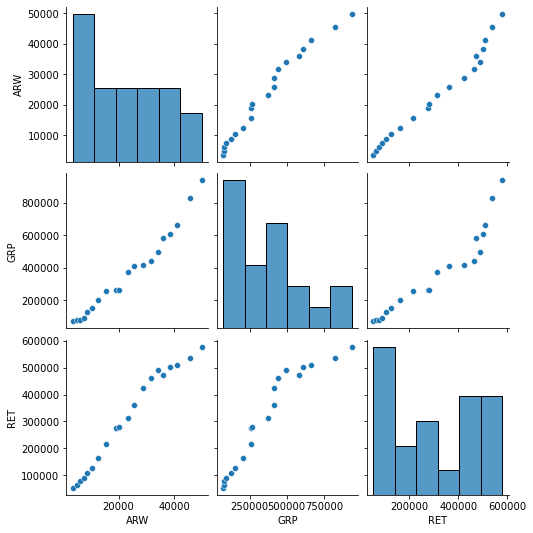

In [29]:
sns.pairplot(df[["ARW",'GRP','RET']]);

In [30]:
df_razn_1 = df.loc[1:].reset_index().drop(columns=["t","index"]) - df.loc[:18].reset_index().drop(columns=["t","index"])
df_razn_1.drop(['EMPR', 'POVR'], axis=1).corr()

,ARW,GRP,RET,INFL
ARW,1.000000,0.645973,0.581075,0.401604
GRP,0.645973,1.000000,-0.057478,0.360324
RET,0.581075,-0.057478,1.000000,0.247431
INFL,0.401604,0.360324,0.247431,1.000000


In [31]:
df_chou = df[["t","ARW"]]
df_chou

,t,ARW
0,2000,3503.4
1,2001,4813.3
2,2002,6171.4
3,2003,7366.8
4,2004,8673.7
5,2005,10502.4
6,2006,12471.7
7,2007,15510.0
8,2008,18934.7
9,2009,20277.0


In [32]:
chou_1 = df_chou.loc[:4]
chou_2 = df_chou.loc[12:14]

In [33]:
chou = pd.concat([chou_1,chou_2])
chou["t"] = np.arange(1,9)
chou

,t,ARW
0,1,3503.4
1,2,4813.3
2,3,6171.4
3,4,7366.8
4,5,8673.7
12,6,28672.4
13,7,31622.6
14,8,34178.2


In [34]:
chou_model_1 = smf.ols('ARW ~ t', data=chou_1).fit()
chou_model_2 = smf.ols('ARW ~ t', data=chou_2).fit()
chou_model = smf.ols('ARW ~ t', data=chou).fit()
chou_model_1.resid

0   -23.50
1    -3.01
2    65.68
3   -28.33
4   -10.84
dtype: float64

In [35]:
SS0 = np.sum(chou_model.resid)
SS1 = np.sum(chou_model_1.resid)
SS2 = np.sum(chou_model_2.resid)
F = (SS0-(SS1+SS2))/(SS1+SS2)*(len(chou)-4)/2
Ftabl = 6.94427191
F

-1.9981400339801485

In [36]:
# критические значения критерия Дарбина-Уотсона для исследуемых данных (при n = 4 и m = 2,3,4)
d_2_l = 0.86
d_2_u = 1.27
d_3_l = 0.77
d_3_u = 1.41
d_4_l = 0.68
d_4_u = 1.57

In [37]:
def get_DW(string):
    # 1 - автокоррел, 2 - нет автокоррел, 3 - неизвестно
    n = get_len_model(string)
    res = model.summary().tables[2].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    dw = float(res.columns[-1])
    if n == 2:
        d_l, d_u = d_2_l, d_2_u
    elif n == 3:
        d_l, d_u = d_3_l, d_3_u
    elif n == 4:
        d_l, d_u = d_4_l, d_4_u
    if 0 <= dw <= d_l:
        return (1, 0, dw, d_l)
    elif d_l < dw <= d_u:
        return (3, d_l, dw, d_u)
    elif d_u < dw  <= 4 - d_u:
        return (2, d_u, dw, 4 - d_u)
    else:
        return (1, 4 - d_u, dw, 4)
        
def get_len_model(string):
    return len(string.replace("+", " ").replace("~", " ").split()[1:])

def pearson_correl():
    return pearsonr(model.resid[1:],model.resid[:-1])
def get_fun_str(string):
    string = string.replace("np.log(ARW)", "ln(ARW)").replace("~","=").replace("np.log(GRP)", "ln(GRP)")
    string = string.replace("np.log(GRP)", "ln(GRP)")
    string = string.replace("np.log(RET)", "ln(RET)")
    string = string.replace("I(1/IPI)", "1/IPI").replace("I(1/INC)", "1/INC")
    string = string.replace("I(1/GRP)", "1/GRP").replace("I(1/RET)", "1/RET")
    return string + " + e"

In [38]:
df_1 = df[["ARW","GRP","RET"]]

# Линейные модели

In [62]:
model = smf.ols('ARW ~ GRP + RET', data=df_1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ARW   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3955.
Date:                Thu, 27 May 2021   Prob (F-statistic):           2.07e-23
Time:                        15:41:54   Log-Likelihood:                -158.08
No. Observations:                  20   AIC:                             322.2
Df Residuals:                      17   BIC:                             325.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    336.7258    323.196      1.042      0.3

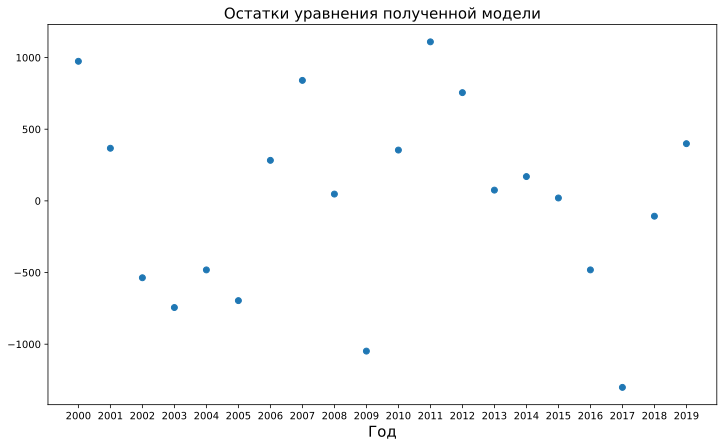

In [70]:
%config InlineBackend.figure_format = 'svg'
model = smf.ols('ARW ~ GRP + RET', data=df_1).fit()
fig1, ax1 = plt.subplots(figsize = (12, 7))
ax1.scatter(df.t, model.fittedvalues - df.ARW)
ax1.set_title("Остатки уравнения полученной модели", size = 15)
ax1.set_xlabel('Год', size = 15)
plt.xticks(np.arange(2000,2020), np.arange(2000,2020))
plt.show();

In [40]:
model.params

Intercept    336.725842
GRP            0.027784
RET            0.041349
dtype: float64

In [41]:
d = {'Function': [], "DW": [], "DW_Conclusion": [], "Correlation": [],
     "P-value": [], "Significance": []}
f = ['ARW ~ GRP + RET']
f_str = ['ARW = GRP + RET + e']
vid = "Линейная функция"
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Function"].append(fun_str)
    d["DW"].append(dw)
    if flag == 1:
        d["DW_Conclusion"].append("Случайные остатки коррелируемы")
    elif flag == 2:
        d["DW_Conclusion"].append("Случайные остатки некоррелируемы")
    else:
        d["DW_Conclusion"].append("Зона неопределенности")
    d["Correlation"].append(np.round(r, 4))
    d["P-value"].append(np.round(pvalue, 4))
    if pvalue < 0.05:
        d["Significance"].append("Коэффициент корреляции значим")
    else:
        d["Significance"].append("Коэффициент корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod

,Function,DW,DW_Conclusion,Correlation,P-value,Significance
0,ARW = GRP + RET + e,1.188,Зона неопределенности,0.3641,0.1254,Коэффициент корреляции незначим


# Показательные модели

In [42]:
model_pok = smf.ols('np.log(ARW) ~ GRP + RET', data=df_1).fit()
print(model_pok.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(ARW)   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     123.8
Date:                Thu, 27 May 2021   Prob (F-statistic):           7.34e-11
Time:                        15:40:13   Log-Likelihood:                 4.0625
No. Observations:                  20   AIC:                            -2.125
Df Residuals:                      17   BIC:                            0.8621
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.4964      0.097     87.229      0.0

In [43]:
f = ['np.log(ARW) ~ GRP + RET']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Function"].append(fun_str)
    d["DW"].append(dw)
    if flag == 1:
        d["DW_Conclusion"].append("Случайные остатки коррелируемы")
    elif flag == 2:
        d["DW_Conclusion"].append("Случайные остатки некоррелируемы")
    else:
        d["DW_Conclusion"].append("Зона неопределенности")
    d["Correlation"].append(np.round(r, 4))
    d["P-value"].append(np.round(pvalue, 4))
    if pvalue < 0.05:
        d["Significance"].append("Коэффициент корреляции значим")
    else:
        d["Significance"].append("Коэффициент корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod

,Function,DW,DW_Conclusion,Correlation,P-value,Significance
0,ARW = GRP + RET + e,1.188,Зона неопределенности,0.3641,0.1254,Коэффициент корреляции незначим
1,ln(ARW) = GRP + RET + e,0.320,Случайные остатки коррелируемы,0.8371,0.0000,Коэффициент корреляции значим


# Степенные модели

In [44]:
model_step = smf.ols('np.log(ARW) ~ np.log(GRP) + np.log(RET)', data=df_1).fit()
print(model_step.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(ARW)   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1215.
Date:                Thu, 27 May 2021   Prob (F-statistic):           4.51e-19
Time:                        15:40:14   Log-Likelihood:                 26.307
No. Observations:                  20   AIC:                            -46.61
Df Residuals:                      17   BIC:                            -43.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.5127      0.250    -10.036      

In [45]:
f = ['np.log(ARW) ~ np.log(GRP) + np.log(RET)']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Function"].append(fun_str)
    d["DW"].append(dw)
    if flag == 1:
        d["DW_Conclusion"].append("Случайные остатки коррелируемы")
    elif flag == 2:
        d["DW_Conclusion"].append("Случайные остатки некоррелируемы")
    else:
        d["DW_Conclusion"].append("Зона неопределенности")
    d["Correlation"].append(np.round(r, 4))
    d["P-value"].append(np.round(pvalue, 4))
    if pvalue < 0.05:
        d["Significance"].append("Коэффициент корреляции значим")
    else:
        d["Significance"].append("Коэффициент корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod

,Function,DW,DW_Conclusion,Correlation,P-value,Significance
0,ARW = GRP + RET + e,1.188,Зона неопределенности,0.3641,0.1254,Коэффициент корреляции незначим
1,ln(ARW) = GRP + RET + e,0.320,Случайные остатки коррелируемы,0.8371,0.0000,Коэффициент корреляции значим
2,ln(ARW) = ln(GRP) + ln(RET) + e,0.701,Случайные остатки коррелируемы,0.5918,0.0076,Коэффициент корреляции значим


# Полулогарифмическая модель

In [46]:
model_pollog = smf.ols('ARW ~ np.log(GRP) + np.log(RET)', data=df_1).fit()
print(model_pollog.summary())

                            OLS Regression Results                            
Dep. Variable:                    ARW   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     141.6
Date:                Thu, 27 May 2021   Prob (F-statistic):           2.51e-11
Time:                        15:40:14   Log-Likelihood:                -190.82
No. Observations:                  20   AIC:                             387.6
Df Residuals:                      17   BIC:                             390.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.876e+05    1.3e+04    -14.450      

In [47]:
f = ['ARW ~ np.log(GRP) + np.log(RET)']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Function"].append(fun_str)
    d["DW"].append(dw)
    if flag == 1:
        d["DW_Conclusion"].append("Случайные остатки коррелируемы")
    elif flag == 2:
        d["DW_Conclusion"].append("Случайные остатки некоррелируемы")
    else:
        d["DW_Conclusion"].append("Зона неопределенности")
    d["Correlation"].append(np.round(r, 4))
    d["P-value"].append(np.round(pvalue, 4))
    if pvalue < 0.05:
        d["Significance"].append("Коэффициент корреляции значим")
    else:
        d["Significance"].append("Коэффициент корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod

,Function,DW,DW_Conclusion,Correlation,P-value,Significance
0,ARW = GRP + RET + e,1.188,Зона неопределенности,0.3641,0.1254,Коэффициент корреляции незначим
1,ln(ARW) = GRP + RET + e,0.320,Случайные остатки коррелируемы,0.8371,0.0000,Коэффициент корреляции значим
2,ln(ARW) = ln(GRP) + ln(RET) + e,0.701,Случайные остатки коррелируемы,0.5918,0.0076,Коэффициент корреляции значим
3,ARW = ln(GRP) + ln(RET) + e,0.627,Случайные остатки коррелируемы,0.6744,0.0015,Коэффициент корреляции значим


# Гиперболическая модель

In [48]:
f = ['ARW ~ I(1/GRP) + I(1/RET)']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Function"].append(fun_str)
    d["DW"].append(dw)
    if flag == 1:
        d["DW_Conclusion"].append("Случайные остатки коррелируемы")
    elif flag == 2:
        d["DW_Conclusion"].append("Случайные остатки некоррелируемы")
    else:
        d["DW_Conclusion"].append("Зона неопределенности")
    d["Correlation"].append(np.round(r, 4))
    d["P-value"].append(np.round(pvalue, 4))
    if pvalue < 0.05:
        d["Significance"].append("Коэффициент корреляции значим")
    else:
        d["Significance"].append("Коэффициент корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod

,Function,DW,DW_Conclusion,Correlation,P-value,Significance
0,ARW = GRP + RET + e,1.188,Зона неопределенности,0.3641,0.1254,Коэффициент корреляции незначим
1,ln(ARW) = GRP + RET + e,0.320,Случайные остатки коррелируемы,0.8371,0.0000,Коэффициент корреляции значим
2,ln(ARW) = ln(GRP) + ln(RET) + e,0.701,Случайные остатки коррелируемы,0.5918,0.0076,Коэффициент корреляции значим
3,ARW = ln(GRP) + ln(RET) + e,0.627,Случайные остатки коррелируемы,0.6744,0.0015,Коэффициент корреляции значим
4,ARW = 1/GRP + 1/RET + e,0.269,Случайные остатки коррелируемы,0.8584,0.0000,Коэффициент корреляции значим


In [49]:
d = {'Модель': [], "ДУ": [], "Вывод - ДУ": [], "ACF1": [],
     "p-значение ACF1": [], "Вывод - ACF1": []}
f = ['ARW ~ GRP + RET', 'np.log(ARW) ~ GRP + RET',
     'np.log(ARW) ~ np.log(GRP) + np.log(RET)',
    'ARW ~ np.log(GRP) + np.log(RET)',
    'ARW ~ I(1/GRP) + I(1/RET)']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    flag, left, dw, right = get_DW(fun)
    r, pvalue = pearson_correl()
    d["Модель"].append(fun_str)
    d["ДУ"].append(np.round(dw,2))
    if flag == 1:
        d["Вывод - ДУ"].append("neg")
    elif flag == 2:
        d["Вывод - ДУ"].append("pos")
    else:
        d["Вывод - ДУ"].append("unknown")
    d["ACF1"].append(np.round(r, 2))
    d["p-значение ACF1"].append(np.round(pvalue, 2))
    if pvalue < 0.05:
        d["Вывод - ACF1"].append("Коэф. корреляции значим")
    else:
        d["Вывод - ACF1"].append("Коэф. корреляции незначим")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod.style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')] ) ])

,Модель,ДУ,Вывод - ДУ,ACF1,p-значение ACF1,Вывод - ACF1
0,ARW = GRP + RET + e,1.190000,unknown,0.360000,0.130000,Коэф. корреляции незначим
1,ln(ARW) = GRP + RET + e,0.320000,neg,0.840000,0.000000,Коэф. корреляции значим
2,ln(ARW) = ln(GRP) + ln(RET) + e,0.700000,neg,0.590000,0.010000,Коэф. корреляции значим
3,ARW = ln(GRP) + ln(RET) + e,0.630000,neg,0.670000,0.000000,Коэф. корреляции значим
4,ARW = 1/GRP + 1/RET + e,0.270000,neg,0.860000,0.000000,Коэф. корреляции значим


In [50]:
df_residuals_mod.iloc[[0, 2]]

,Модель,ДУ,Вывод - ДУ,ACF1,p-значение ACF1,Вывод - ACF1
0,ARW = GRP + RET + e,1.19,unknown,0.36,0.13,Коэф. корреляции незначим
2,ln(ARW) = ln(GRP) + ln(RET) + e,0.70,neg,0.59,0.01,Коэф. корреляции значим


# Проверка остатков на гомоскедастичность.

In [51]:
model = smf.ols('ARW ~ GRP + RET', data=df_1).fit()
df_hom = pd.DataFrame()
df_hom["e"] = model.resid
df_hom["x1"] = df_1.GRP
df_hom['x2'] = df_1.RET

In [52]:
# Тест Уайта
model = smf.ols('I(e * e) ~ x1 + x2', data=df_hom).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               I(e * e)   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.111
Method:                 Least Squares   F-statistic:                   0.05383
Date:                Thu, 27 May 2021   Prob (F-statistic):              0.948
Time:                        15:40:16   Log-Likelihood:                -289.55
No. Observations:                  20   AIC:                             585.1
Df Residuals:                      17   BIC:                             588.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    4.71e+05   2.31e+05      2.036      0.0

In [53]:
# тест Парка
model = smf.ols('np.log(I(e * e)) ~ np.log(x2)', data=df_hom).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(I(e * e))   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.324
Date:                Thu, 27 May 2021   Prob (F-statistic):              0.145
Time:                        15:40:17   Log-Likelihood:                -43.085
No. Observations:                  20   AIC:                             90.17
Df Residuals:                      18   BIC:                             92.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.6478      7.815      3.026      0.0

In [54]:
# тест Глейзера
model = smf.ols('I(abs(e)) ~ I(x2 ** (2))', data=df_hom).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              I(abs(e))   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9562
Date:                Thu, 27 May 2021   Prob (F-statistic):              0.341
Time:                        15:40:17   Log-Likelihood:                -146.23
No. Observations:                  20   AIC:                             296.5
Df Residuals:                      18   BIC:                             298.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      634.1336    128.963      4.917   

# Проверка остатков на нормальность.

In [55]:
def JB():
    res = model.summary().tables[2].as_html()
    res = pd.read_html(res, header=0, index_col=0)[0]
    jb = res.iloc[0][2]
    return jb

def RS():
    R = np.max(model.resid) - np.min(model.resid)
    S = (np.sum(model.resid ** 2)/23) ** 0.5
    return R/S

In [56]:
d = {'Модель': [], "Значение Жака-Бера": [], "Итог - Жака-Бера": [], "Значение RS": [],
     "Итог - RS": []}
f = ['ARW ~ GRP + RET']
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    jb = JB()
    rs = RS()
    d["Модель"].append(fun_str)
    d["Значение Жака-Бера"].append(np.round(jb,2))
    d["Значение RS"].append(np.round(rs,2))
    if jb < 5.99:
        d["Итог - Жака-Бера"].append("Остатки нормальны")
    else:
        d["Итог - Жака-Бера"].append("Остатки ненормальны")
    if 3.25 <= rs <= 4.6:
        d["Итог - RS"].append("Остатки нормальны")
    else:
        d["Итог - RS"].append("Остатки ненормальны")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod.style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')] ) ])

,Модель,Значение Жака-Бера,Итог - Жака-Бера,Значение RS,Итог - RS
0,ARW = GRP + RET + e,0.630000,Остатки нормальны,3.950000,Остатки нормальны


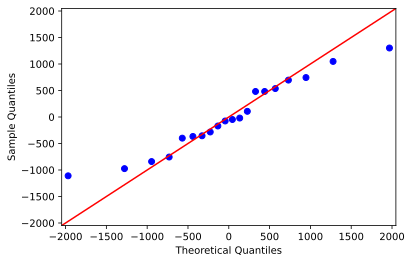

In [57]:
%config InlineBackend.figure_format = 'svg'
from matplotlib import pyplot as plt
import scipy.stats as stats
fig = sm.qqplot(model.resid, stats.t, distargs=(2,),loc=np.mean(model.resid), scale=np.std(model.resid), line='45')
plt.show()

In [58]:
f = f
d = {'Модель': [], "ADF": [], "p-значение ADF": [], "Стационарность остатков":[]}
f_str = [get_fun_str(fun) for fun in f]
for fun, fun_str in zip(f, f_str):
    model = smf.ols(fun, data=df_1).fit()
    adf = adfuller(model.resid)
    d["Модель"].append(fun_str)
    d["ADF"].append(np.round(adf[0],2))
    d["p-значение ADF"].append(np.round(adf[1],2))
    if adf[1] < 0.05:
        d["Стационарность остатков"].append("Ряд остатков стационарен")
    else:
        d["Стационарность остатков"].append("Ряд остатков нестационарен")
df_residuals_mod = pd.DataFrame(d)
df_residuals_mod.style.set_properties(**{'text-align': 'center'}).set_table_styles([ dict(selector='th', props=[('text-align', 'center')] ) ])

,Модель,ADF,p-значение ADF,Стационарность остатков
0,ARW = GRP + RET + e,-2.120000,0.240000,Ряд остатков нестационарен


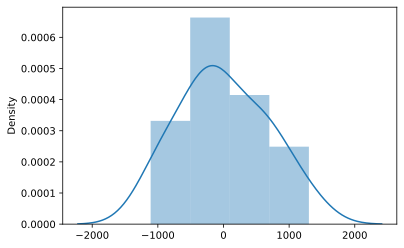

In [59]:
fig1, ax1 = plt.subplots()
sns.distplot(model.resid, bins=4);

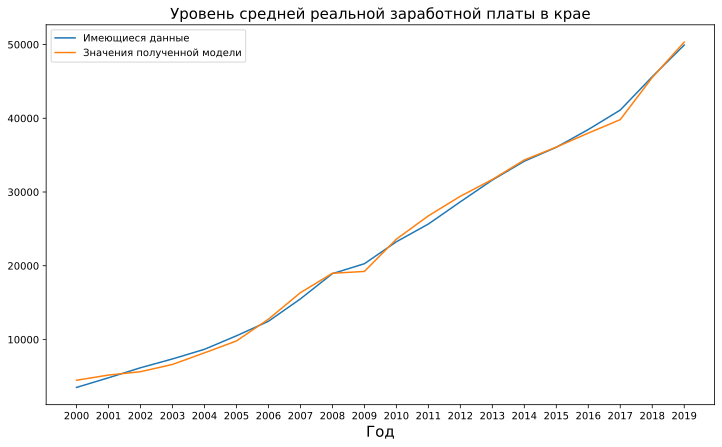

In [52]:
%config InlineBackend.figure_format = 'svg'
model = smf.ols('ARW ~ GRP + RET', data=df_1).fit()
fig1, ax1 = plt.subplots(figsize = (12, 7))
ax1.plot(df.t, df.ARW, label = 'Имеющиеся данные')
ax1.plot(df.t, model.fittedvalues, label = 'Значения полученной модели')
ax1.set_title("Уровень средней реальной заработной платы в крае", size = 15)
ax1.set_xlabel('Год', size = 15)
ax1.legend(loc = 'upper left')
plt.xticks(np.arange(2000,2020), np.arange(2000,2020))
plt.show();